In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
engine = create_engine('sqlite:///data.sqlite')

In [3]:
conn = engine.connect()

In [5]:
fires_df = pd.read_sql("SELECT * FROM fires", conn)

In [34]:
fire_size_cause_df = pd.read_sql("SELECT FIRE_SIZE, NWCG_CAUSE_CLASSIFICATION FROM fires", conn)
fire_size_cause_df = fire_size_cause_df.groupby('NWCG_CAUSE_CLASSIFICATION').sum()

fire_count_cause_df = pd.read_sql("SELECT FIRE_COUNT, NWCG_CAUSE_CLASSIFICATION FROM fires", conn)
fire_count_cause_df = fire_count_cause_df.groupby('NWCG_CAUSE_CLASSIFICATION').sum()






OperationalError: (sqlite3.OperationalError) no such column: FIRE_COUNT
[SQL: SELECT FIRE_COUNT, NWCG_CAUSE_CLASSIFICATION FROM fires]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

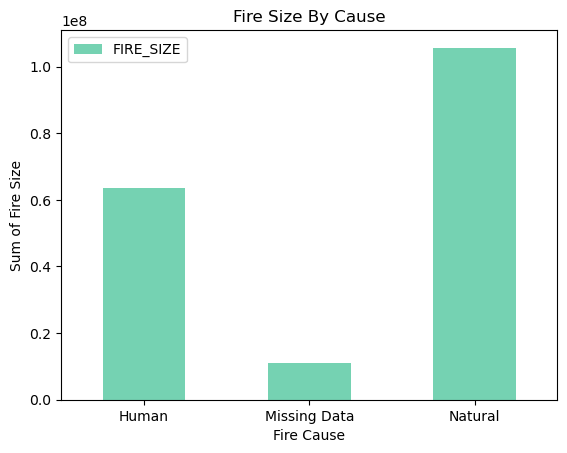

In [36]:
ax = fire_size_cause_df.plot.bar(color="mediumaquamarine", alpha=0.90, align="center")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels(["Human","Missing Data","Natural"])
plt.title("Fire Size By Cause")
plt.xlabel("Fire Cause")
plt.ylabel("Sum of Fire Size")
plt.show()

In [ ]:
ax = fire_count_cause_df.plot.bar(color="purple", alpha=0.80, align="center")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticklabels(["Human","Missing Data","Natural"])
plt.title("Fire Size By Cause")
plt.xlabel("Fire Cause")
plt.ylabel("Sum of Fire Size")
plt.show()

In [ ]:
# # Time checker
# start_time = time.time()
# print("--- %s seconds ---" % (time.time() - start_time))